# Removing MR-related artifact and cleaning ECG data
Acquired during a multi-echo, simultaneous multislice EPI scan collected while participants performed tasks and watched movies in a 3T Siemens PRISMA scanner.

In [1]:
import json
import bioread as br
import scipy.signal as signal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')

In [2]:
import scipy
print('SciPy version', scipy.__version__)

import numpy
print('Numpy version', numpy.__version__)

import pandas
print('Pandas version', pandas.__version__)

import bioread
print('bioread version', bioread.__version__)

import sys 
print("Python version", sys.version) 

SciPy version 1.5.1
Numpy version 1.19.0
Pandas version 1.0.5
bioread version 1.0.4
Python version 3.7.8 (v3.7.8:4b47a5b6ba, Jun 27 2020, 04:47:50) 
[Clang 6.0 (clang-600.0.57)]


In [3]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def consecutive(data, stepsize=0.000501):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def comb_band_stop(notches, filtered, Q, fs):
    for notch in notches:
        print(notch)
        for i in np.arange(1, (nyquist / notches[notch])):
            #print(notches[notch] * i)
            f0 = notches[notch] * i
            w0 = f0/nyquist
            b,a = signal.iirnotch(w0, Q)
            filtered = signal.filtfilt(b, a, filtered)
    return filtered

## Read in the AcqKnowlege file from our pilot participant
Bioread is a python package for reading AcqKnowledge files into python as dictionaries. The second line just checks on the names of each channel and the data contained.

In [4]:
mbme_data = br.read_file('../example_data/sub-Bubbles_ses-02.acq')

In [5]:
mbme_data.named_channels

{'ECG100C - ECG100C': Channel ECG100C - ECG100C: 16557045 samples, 2000.0 samples/sec, loaded: True,
 'DA100C - TSD221-MRI - Respiration Trans': Channel DA100C - TSD221-MRI - Respiration Trans: 16557045 samples, 2000.0 samples/sec, loaded: True,
 'EDA100C - EDA100C-MRI': Channel EDA100C - EDA100C-MRI: 16557045 samples, 2000.0 samples/sec, loaded: True,
 'Trigger': Channel Trigger: 16557045 samples, 2000.0 samples/sec, loaded: True}

In [6]:
mbme_data.named_channels['ECG100C - ECG100C'].units

'mV'

In [7]:
sbse_data = br.read_file('../example_data/4232_2_ Musser_K23_redux.acq')

In [8]:
sbse_data.named_channels

{'ECG100C': Channel ECG100C: 7092626 samples, 2000.0 samples/sec, loaded: True,
 'TSD221-MRI - Respiration Transducer, MR': Channel TSD221-MRI - Respiration Transducer, MR: 7092626 samples, 2000.0 samples/sec, loaded: True,
 'EDA100C-MRI': Channel EDA100C-MRI: 7092626 samples, 2000.0 samples/sec, loaded: True,
 'Digital input': Channel Digital input: 7092626 samples, 2000.0 samples/sec, loaded: True}

## Organize timeseries into dataframe with common index (time)
Dictionaries are nice and all, but I can put the timeseries into one dataframe and then subset them more easily, as they'll all be organized according to a common timing index, from the AcqKnowledge file. This makes it easier to subset the data (i.e., extract EPI signal based on presence of 5V signal in the `digital input` channel.

In [9]:
#organizing data from the AcqKnowlege file into a pandas dataframe 
#one column per channel, with a common index (time)
timeseries = pd.DataFrame(columns=['ECG', 'EPI', 'seconds'])

timeseries['EPI'] = mbme_data.named_channels['Trigger'].data
timeseries['ECG'] = mbme_data.named_channels['ECG100C - ECG100C'].data
timeseries['seconds'] = mbme_data.time_index

## Extract timeseries collected during EPI scans
Where `Digital input` is 5V, there was an EPI scan running. We can calculate interfering freqencies by assessing the ECG signal during these segments of time.

In [10]:
fives = timeseries[timeseries['EPI'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [11]:
#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
epi_ts = timeseries[timeseries['EPI'] == 5]
epi_ts.drop(columns='EPI', inplace=True)

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


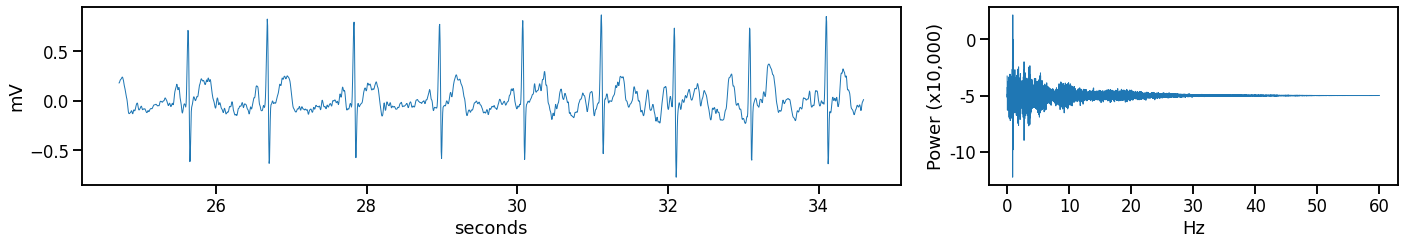

In [12]:
fft_ecg = np.fft.fft(timeseries['ECG'][:1000000])
freq = np.fft.fftfreq(timeseries['ECG'][:1000000].shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))

gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(timeseries['seconds'][50000:80000],10)[:2000], 
             signal.decimate(timeseries['ECG'][50000:80000], 10)[:2000], 
             linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:30000], 
             fft_ecg.real[:30000], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
#ax3.set_xlabel('Hz')
ax2.set_xlabel('Hz')
ax2.set_yticklabels([0,-10, -5, 0, 5])
ax2.set_ylabel('Power (x10,000)')
plt.show()
fig.savefig('../figures/me_sms-ecg-fft_raw-noepi.png', dpi=300)

In [13]:
timeseries[timeseries['EPI'] == 5].loc[2397429]

ECG          -0.106506
EPI           5.000000
seconds    1198.714572
Name: 2397429, dtype: float64

## Filtering the data!
First, we did a Fourier transform on the EPI-corrupted ECG signal to look for interfering freqiencies. We plotted the Fourier transformed data, as well as the log-transformed Fourier transformed data, for signal power in decibels.

In [14]:
epi_ts.std()
s01e02r01 = epi_ts['ECG'][:954000]

In [15]:
epi_ts['ECG'][:954000]

2397429   -0.106506
2397430   -0.141296
2397431   -0.179138
2397432   -0.218201
2397433   -0.259399
             ...   
3408650    0.201721
3408651    0.207520
3408652    0.215149
3408653    0.222168
3408654    0.230408
Name: ECG, Length: 954000, dtype: float64

In [16]:
fft_ecg = np.fft.fft(s01e02r01)
freq = np.fft.fftfreq(s01e02r01.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
print(np.unique(abs(freq[np.where(fft_ecg > 4)])))

[0.00000000e+00 4.82180294e-02 5.03144654e-02 ... 1.94685535e+02
 2.16002096e+02 2.48666667e+02]


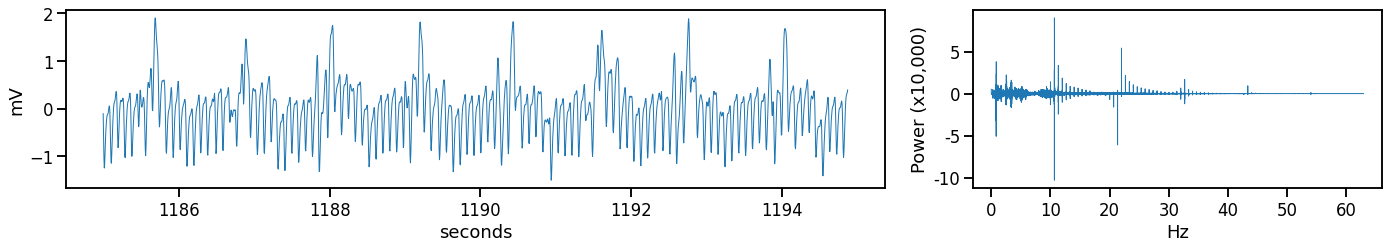

In [17]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(epi_ts['seconds'][:954000], 10)[:2000], 
             signal.decimate(s01e02r01, 10)[:2000], 
             linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:30000], 
             fft_ecg.real[:30000], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
#ax3.set_xlabel('Hz')
ax2.set_xlabel('Hz')
ax2.set_yticklabels([0,-10, -5, 0, 5])
ax2.set_ylabel('Power (x10,000)')
plt.show()

fig.savefig('../figures/me_sms-ecg-fft_raw.png', dpi=300)

### Assembling a pseudo comb band stop filter out of IIR notch filters.
Because comb filters aren't implemented in scipy, as far as I can tell. I don't think this is equivalent, but to my knowledge, it's achieving the same end (filtering out the interfering frequencies and their aliases up to Nyquist frequency).

In [18]:
#arranging noisy frequencies to be filtered out
slices = 48
mb = 3
tr = 1.5

notches = {
          #'te1': 1 / 0.01180, #I'm not sure the TEs are necessary?  
          #'te2': 1 / 0.02804, #Or that they should be treated like this?
          #'te3': 1 / 0.04428,
          #'te4': 1 / 0.06052, 
           'slices': slices / mb / tr, 
           'tr': 1 / 1.5}      #turns out those evenly-spaced interfering frequencies are 0.66Hz apart


fs = 2000.
hp = 1.
lp = 40.


#I don't know if this is right, been playing around with the volume of Q
Q = 100

nyquist = fs/2

### First, we filtered out respiration-related noise with a 1Hz highpass filter

In [19]:
#remove respiration-related noise
filtered = butter_highpass_filter(epi_ts['ECG'], hp, fs)


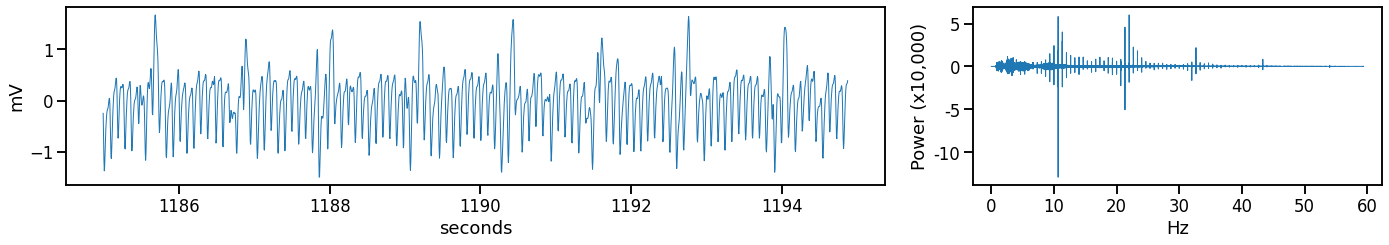

In [20]:
fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(filtered))


gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))

plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(epi_ts['seconds'][:954000], 10)[:2000], 
             signal.decimate(filtered, 10)[:2000], 
             linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:300000], 
             fft_filt.real[:300000], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
#ax3.set_xlabel('Hz')
ax2.set_xlabel('Hz')
ax2.set_yticklabels([0,-10, -5, 0, 5])
ax2.set_ylabel('Power (x10,000)')
plt.show()
fig.savefig('../figures/me_sms-ecg-fft_respfilt.png', dpi=300)

### Then we performed iterations of the IIR notch filter, to simulate a comb band stop filter
Each notch represents either a frequency of interest (see `notches` dictionary above) or one of its harmonics, up to Nyquist.

In [21]:
filtered = comb_band_stop(notches, filtered, Q, fs)

slices
tr


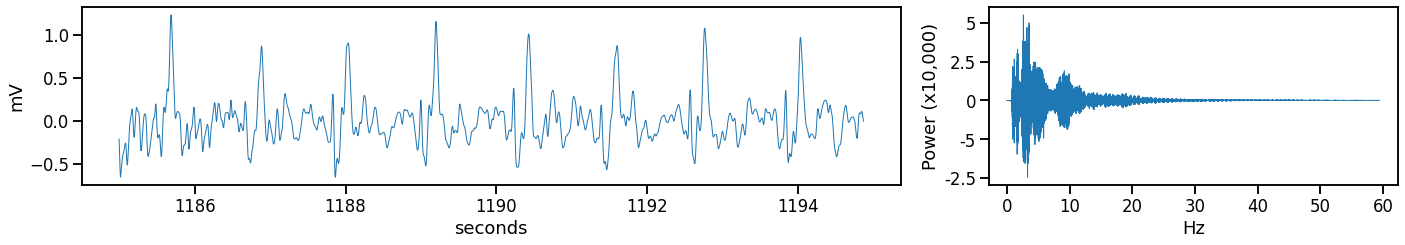

In [22]:
fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(filtered))

gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))

plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(epi_ts['seconds'][:954000], 10)[:2000], 
             signal.decimate(filtered, 10)[:2000], 
             linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:300000], 
             fft_filt.real[:300000], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
#ax3.set_xlabel('Hz')
ax2.set_xlabel('Hz')
ax2.set_yticklabels([0,-2.5, -5, 0, 2.5, 5])
ax2.set_ylabel('Power (x10,000)')
plt.show()
fig.savefig('../figures/me_sms-ecg-fft_epifilt.png', dpi=300)

### Then the data is further filtered with a 40Hz lowpass filter, per BioPac App 242
Filter is shown, for a sanity check.

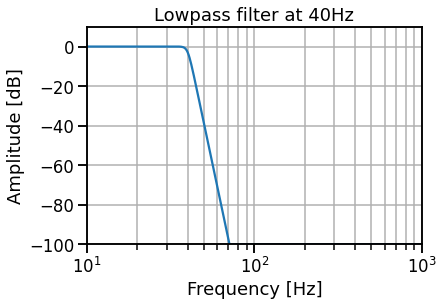

In [23]:
#lowpass IIR filter noise, per BioPac App242 instructions
sos = signal.iirfilter(20, 40, btype='lowpass', output='sos', fs=fs)
w, h = signal.sosfreqz(sos, 2000, fs=2000)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('Lowpass filter at 40Hz')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

filtered_lp = signal.sosfiltfilt(sos, filtered)

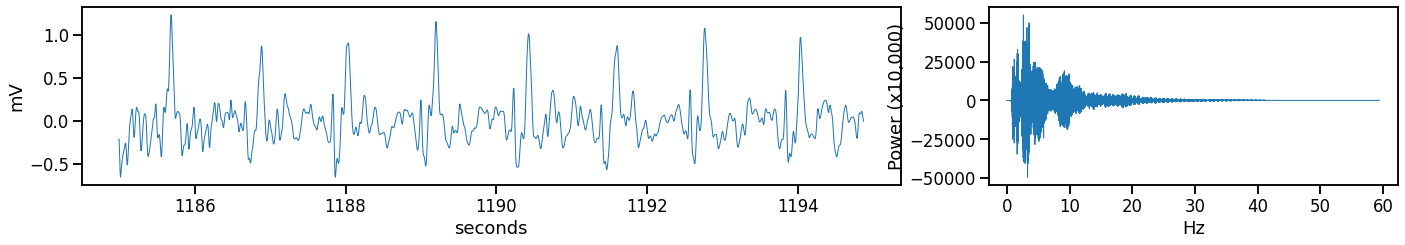

In [24]:
fft_filt = np.fft.fft(filtered_lp)
freq = np.fft.fftfreq(filtered_lp.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(filtered))

gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))

plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(epi_ts['seconds'][:954000], 10)[:2000], 
             signal.decimate(filtered, 10)[:2000], 
             linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:300000], 
             fft_filt.real[:300000], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
#ax3.set_xlabel('Hz')
ax2.set_xlabel('Hz')
ax2.set_ylabel('Power (x10,000)')
plt.show()
fig.savefig('../figures/me_sms-ecg-fft_epifilt_lp.png', dpi=300)

### And QRS is (ideally) isolated with a 17Hz bandpass filter, per BioPac App 242
Parameters (Q, w0) are from BioPac app. Filter shown for sanity check.

In [25]:
#bandpass around 17Hz  per BioPac App242 instructions
f0 = 24.  # Frequency to be retained (Hz)
Q = 6  # Quality factor
w0 = f0/(fs/2)  # Normalized Frequency
# Design peak filter
low = 8 / nyquist
high = 31 / nyquist
order = 5
b, a = signal.butter(order, [low, high], btype='band')
filtered_lp_bp = signal.filtfilt(b, a, filtered_lp)

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


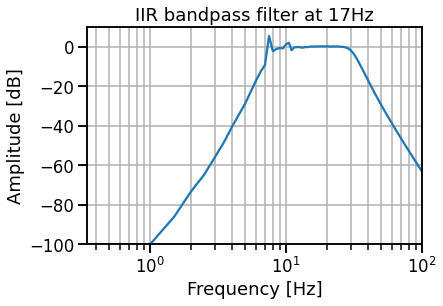

In [26]:
w, h = signal.freqz(b, a, 2000, fs=2000)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('IIR bandpass filter at 17Hz')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((0, 100, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

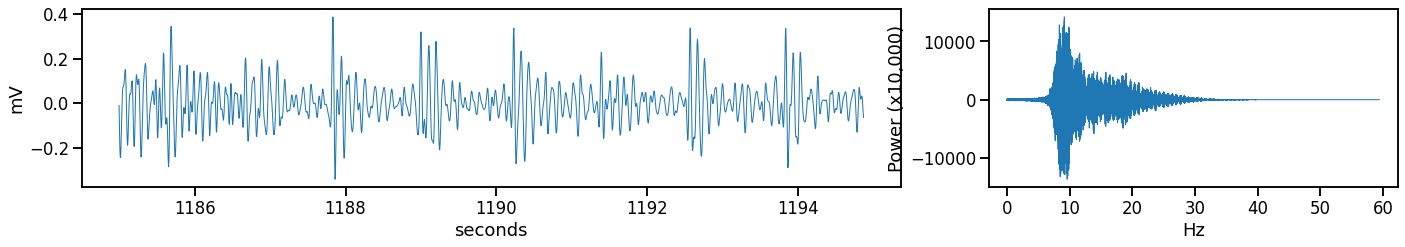

In [27]:
fft_filt = np.fft.fft(filtered_lp_bp)
freq = np.fft.fftfreq(filtered_lp_bp.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(filtered_lp_bp))

gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))

plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(epi_ts['seconds'][:954000], 10)[:2000], 
             signal.decimate(filtered_lp_bp, 10)[:2000], 
             linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:300000], 
             fft_filt.real[:300000], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
#ax3.set_xlabel('Hz')
ax2.set_xlabel('Hz')
ax2.set_ylabel('Power (x10,000)')
plt.show()
fig.savefig('../figures/me_sms-ecg-fft_lp+bpfilt.png', dpi=300)

## Here, ECG signals are plotted for comparison
1. Unfiltered ECG signal recorded before the EPI sequence, before the participant was loaded into the scanner.
2. Unfiltered ECG signal recorded during an EPI sequence.
3. ECG signal after 1Hz lowpass and multiple notch filters.
4. ECG signal after 40Hz lowpass filter.
5. ECG signal after 17Hz, Q=5 IIR bandpass filter.

Text(0.5, 1.0, 'Bandpass filtered EPI signal')

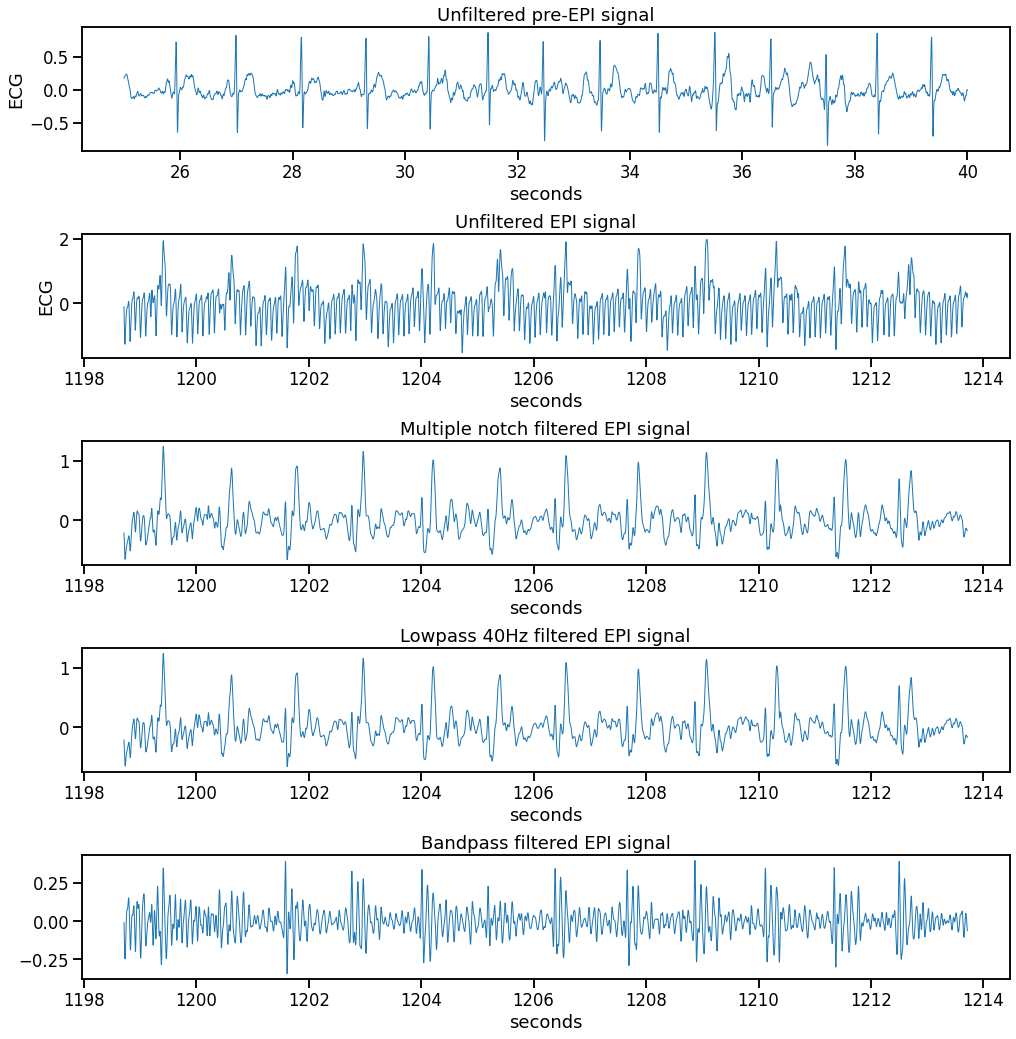

In [28]:
fig,ax = plt.subplots(nrows=5, figsize=(15,15), sharey=False)
plt.tight_layout(pad=2.5)
f = sns.lineplot(timeseries['seconds'][50000:80000], timeseries['ECG'][50000:80000], linewidth=1, ax=ax[0])
f.set_title('Unfiltered pre-EPI signal')
g = sns.lineplot(epi_ts['seconds'][:30000], epi_ts['ECG'][:30000], linewidth=1, ax=ax[1])
g.set_title('Unfiltered EPI signal')
h = sns.lineplot(epi_ts['seconds'][:30000], filtered[:30000], linewidth=1, ax=ax[2])
h.set_title('Multiple notch filtered EPI signal')
i = sns.lineplot(epi_ts['seconds'][:30000], filtered_lp[:30000], linewidth=1, ax=ax[3])
i.set_title('Lowpass 40Hz filtered EPI signal')
j = sns.lineplot(epi_ts['seconds'][:30000], filtered_lp_bp[:30000], linewidth=1, ax=ax[4])
j.set_title('Bandpass filtered EPI signal')

### The fifth plot looks weird.
It's not at all what BioPac's example looks like and not at all like a heart beat waveform. I'm not sure what went wrong with the bandpass filter, but that's got to be the case because the only change from the prior plot is the 17Hz IIR bandpass filter.

In [29]:
fig.savefig('../figures/filtering_ECG.png', dpi=300)